#**Classification par artiste**

###Environnement & dépendances


In [1]:
!pip install keras-tuner --quiet

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras_tuner as kt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import pathlib
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import keras_tuner as kt
import unicodedata


###Chargement des données

In [3]:
!pip install kaggle
!mkdir ~/.kaggle

# ⚠️ Remplace ici par ton vrai username et ta clé depuis le fichier kaggle.json
!echo '{"username":"imen255","key":"1d839887cba13e749f392094b6187ba2"}' > ~/.kaggle/kaggle.json

!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
# Téléchargement
!kaggle datasets download -d ikarus777/best-artworks-of-all-time

# Décompression dans /content/wikiart
!unzip -q best-artworks-of-all-time.zip -d /content/wikiart


Dataset URL: https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time
License(s): CC-BY-NC-SA-4.0
best-artworks-of-all-time.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/wikiart/artists.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
n


In [5]:
# =========================================================
# 1️⃣ Chargement des métadonnées des artistes
# =========================================================
metadata_path = "/content/wikiart/artists.csv"
df_artists = pd.read_csv(metadata_path)

print("✅ Dataset des artistes chargé avec succès !")
print(df_artists.head())

# =========================================================
# 2️⃣ Chargement des images et extraction des artistes
# =========================================================
base_dir = pathlib.Path("/content/wikiart/images")
files = list(base_dir.rglob("*.jpg"))
print(f"🎨 Total d’images trouvées : {len(files)}")

filepaths = []
artists = []

for path in files:
    artist_name = path.parent.name
    filepaths.append(str(path))
    artists.append(artist_name)

df = pd.DataFrame({'filepath': filepaths, 'artist': artists})
print("✅ Exemple de données :", df.head())

# =========================================================
# 3️⃣ Correction des noms mal encodés si nécessaire
# =========================================================
df['artist'] = df['artist'].replace({
    'Albrecht_DuтХа├кrer': 'Albrecht_Durer',
    'Albrecht_Du╠Иrer': 'Albrecht_Durer'
})

# =========================================================
# 4️⃣ Normalisation des noms pour fusion
# =========================================================
def normalize_name(name):
    name = str(name).lower()  # minuscules
    name = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8')  # retirer accents
    name = name.replace(" ", "_")  # remplacer les espaces
    return name

df['artist_clean'] = df['artist'].apply(normalize_name)
df_artists['name_clean'] = df_artists['name'].apply(normalize_name)

# =========================================================
# 5️⃣ Fusion pour associer le genre
# =========================================================
df = df.merge(
    df_artists[['name_clean', 'genre']],
    left_on='artist_clean',
    right_on='name_clean',
    how='left'
)

# Supprimer colonne temporaire
df.drop(columns=['artist_clean', 'name_clean'], inplace=True)

# =========================================================
# 6️⃣ Vérification
# =========================================================
print("✅ Exemple après association du genre :")
print(df[['artist', 'genre']].head(10))

print("\n📊 Statistiques d’association :")
print(df['genre'].value_counts(dropna=False))

# Liste des artistes sans genre associé
missing_genre = df[df['genre'].isna()]['artist'].unique()
if len(missing_genre) > 0:
    print("\n⚠️ Artistes sans genre associé :", missing_genre)
else:
    print("\n🎉 Tous les artistes ont un genre associé !")


✅ Dataset des artistes chargé avec succès !
   id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani  

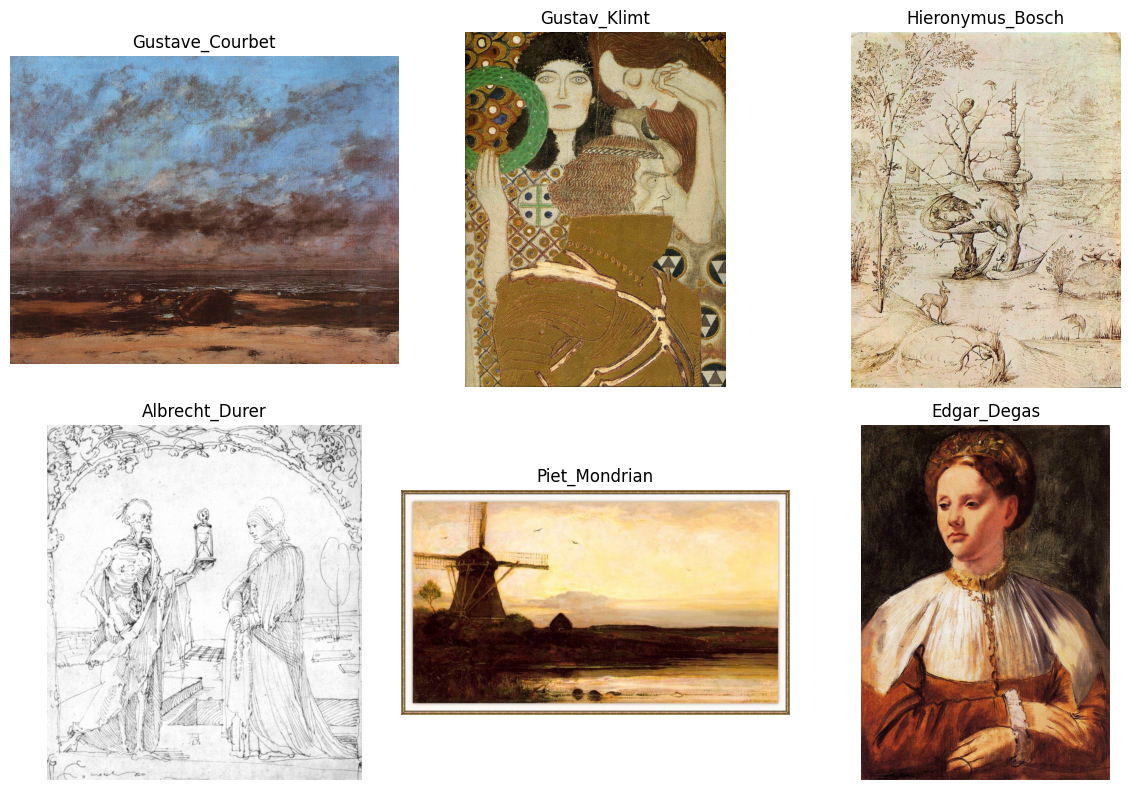

In [6]:
# Visualiser quelques images aléatoires pour vérifier les données
styles = df['artist'].unique()
plt.figure(figsize=(12, 8))

for i, style in enumerate(styles[:6]):  # afficher 6 styles max
    sample = df[df['artist'] == style].sample(1).iloc[0]
    img = mpimg.imread(sample['filepath'])
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(style)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
# 3️⃣ SELECTION DE 5 ARTISTES LES PLUS FRÉQUENTS
# ---------------------------------------------
top5_artists = df['artist'].value_counts().nlargest(5).index
df = df[df['artist'].isin(top5_artists)].reset_index(drop=True)

print("🎯 Artistes sélectionnés :", list(top5_artists))
print(df['artist'].value_counts())

🎯 Artistes sélectionnés : ['Vincent_van_Gogh', 'Edgar_Degas', 'Albrecht_Durer', 'Pablo_Picasso', 'Pierre-Auguste_Renoir']
artist
Vincent_van_Gogh         877
Edgar_Degas              702
Albrecht_Durer           656
Pablo_Picasso            439
Pierre-Auguste_Renoir    336
Name: count, dtype: int64


In [8]:
print("\n📊 Statistiques d’association :")
print(df['genre'].value_counts(dropna=False))



📊 Statistiques d’association :
genre
Impressionism           1038
Post-Impressionism       877
Northern Renaissance     656
Cubism                   439
Name: count, dtype: int64


### ÉQUILIBRAGE DES CLASSES

In [9]:
# =============================================
# 1️⃣ ÉQUILIBRAGE DES CLASSES
# =============================================
min_samples = df['artist'].value_counts().min()
print("⚖️ Chaque artiste aura", min_samples, "images")

balanced_df = (
    df.groupby('artist')
      .apply(lambda x: x.sample(min_samples, random_state=42))
      .reset_index(drop=True)
)

print("✅ Total d’images après équilibrage :", len(balanced_df))

⚖️ Chaque artiste aura 336 images
✅ Total d’images après équilibrage : 1680


/tmp/ipython-input-2436930284.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_samples, random_state=42))


###PRÉPARATION DES IMAGES ET LABELS

In [10]:
# =============================================
# 2️⃣ PRÉPARATION DES IMAGES ET LABELS
# =============================================
IMG_SIZE = 128
images = []
labels = []

for i, row in balanced_df.iterrows():
    img = cv2.imread(row['filepath'])
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
        labels.append(row['artist'])

images = np.array(images, dtype='float32')
labels = np.array(labels)

### Encodage des labels

In [60]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

### DIVISION TRAIN/TEST/VALIDATION

In [61]:
# =============================================
#  DIVISION TRAIN / VALIDATION / TEST
# =============================================

# Étape 1 : train + temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels_encoded,
    test_size=0.3,           # 30% pour val + test
    stratify=labels_encoded,
    random_state=42
)

# Étape 2 : val + test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,           # 15% val + 15% test
    stratify=y_temp,
    random_state=42
)

# Ensure num_classes is correctly set to 5 for artist classification
num_classes = len(le.classes_)

# Encodage one-hot
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"✅ Données prêtes : {X_train.shape} train / {X_val.shape} val / {X_test.shape} test")
print("🎨 Nombre de classes :", num_classes)

✅ Données prêtes : (1176, 128, 128, 3) train / (252, 128, 128, 3) val / (252, 128, 128, 3) test
🎨 Nombre de classes : 4


###NORMALISATION + DATA AUGMENTATION

In [62]:
# =============================================
#  NORMALISATION + DATA AUGMENTATION
# =============================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=32, shuffle=True)
val_generator = val_test_datagen.flow(X_val, y_val_cat, batch_size=32, shuffle=False)
test_generator = val_test_datagen.flow(X_test, y_test_cat, batch_size=32, shuffle=False)

###POIDS DE CLASSES

In [63]:
# =============================================
#  POIDS DE CLASSES
# =============================================
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("⚖️ Poids de classes :", class_weights)

⚖️ Poids de classes : {0: np.float64(1.251063829787234), 1: np.float64(0.6242038216560509), 2: np.float64(1.251063829787234), 3: np.float64(1.251063829787234)}


In [64]:
print("Nombre de classes :", num_classes)
print("Shape y_train_cat :", y_train_cat.shape)

Nombre de classes : 4
Shape y_train_cat : (1176, 4)


### Définition du modèle de base (CNN simple)

In [16]:
# =============================================
# 6️⃣ CONSTRUCTION DU CNN
# =============================================
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,483,397 (32.36 MB)

 Trainable params: 8,483,397 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

### EARLY STOPPING + ENTRAÎNEMENT


In [17]:
# =============================================
# 7️⃣ EARLY STOPPING + ENTRAÎNEMENT
# =============================================
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 278ms/step - accuracy: 0.3118 - loss: 1.8018 - val_accuracy: 0.5198 - val_loss: 1.2161
Epoch 2/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.4765 - loss: 1.2131 - val_accuracy: 0.5159 - val_loss: 1.2009
Epoch 3/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.5162 - loss: 1.1510 - val_accuracy: 0.4683 - val_loss: 1.2833
Epoch 4/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.5268 - loss: 1.1409 - val_accuracy: 0.4960 - val_loss: 1.1314
Epoch 5/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.5594 - loss: 1.0266 - val_accuracy: 0.5198 - val_loss: 1.2309
Epoch 6/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.5824 - loss: 1.0090 - val_accuracy: 0.4683 - val_loss: 1.5362
Epoch 7/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.6061 - loss: 0.9692 - val_accuracy: 0.6111 - val_loss: 1.1095
Epoch 8/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.6224 - loss: 0.9684 - val_accuracy: 0

###ÉVALUATION du modéle CNN simple

In [21]:
# =============================================
#  ÉVALUATION SUR TEST FINAL
# =============================================
loss, acc = model.evaluate(test_generator)
print(f"🎯 Précision finale sur test : {acc*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6243 - loss: 0.9942
🎯 Précision finale sur test : 61.90%


###Courbes d'apprentissage (accuracy & loss)

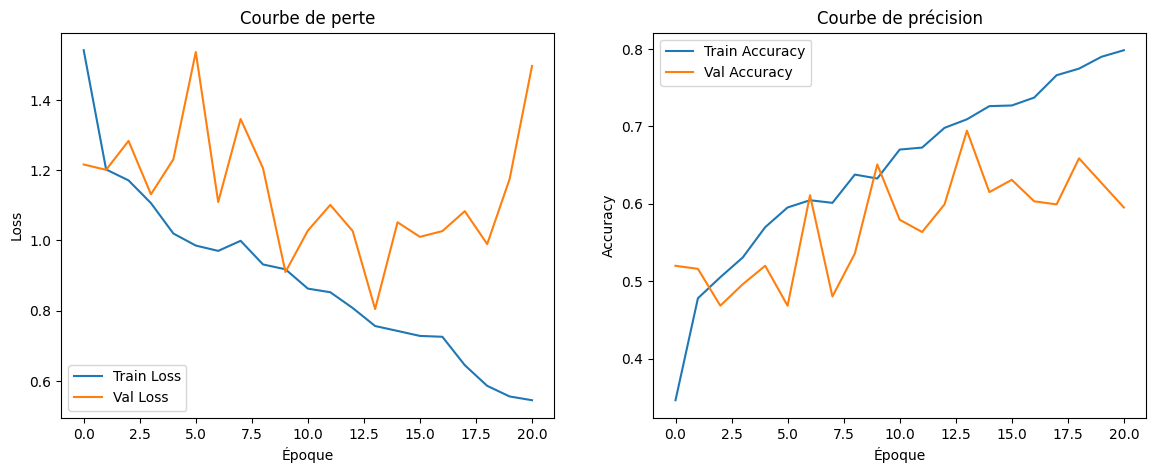

In [19]:
# =============================================
#  Courbes d'apprentissage (accuracy & loss)
# =============================================
plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Courbe de perte')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Courbe de précision')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


###Rapport de classification

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


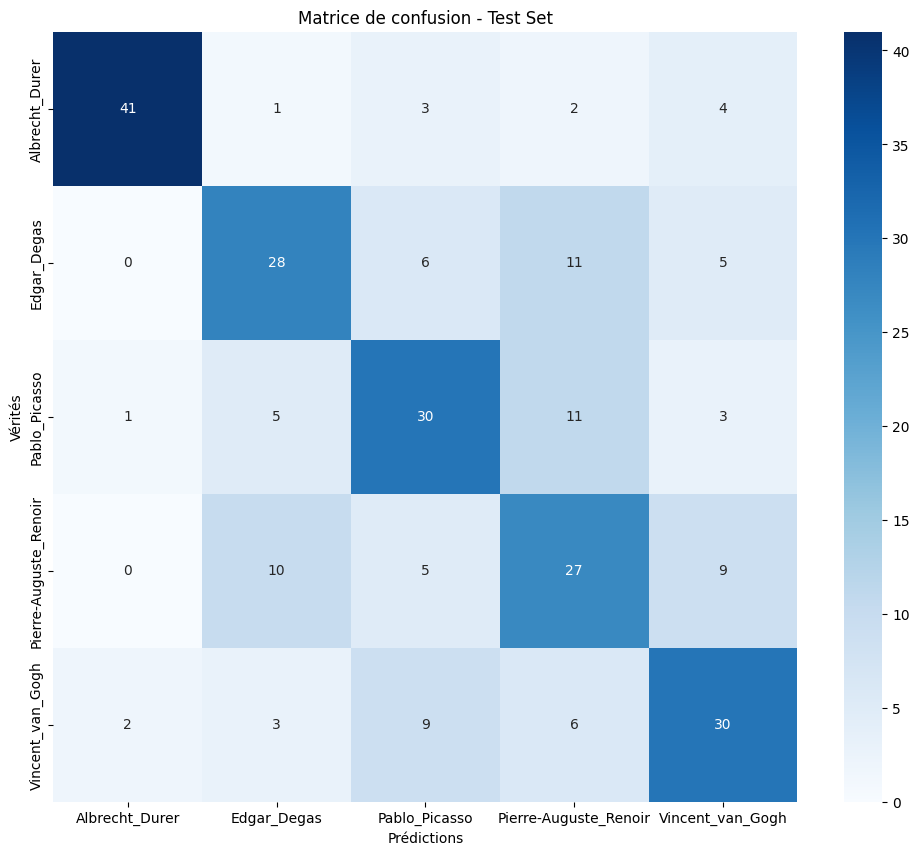

📊 Classification Report :
                        precision    recall  f1-score   support

       Albrecht_Durer       0.93      0.80      0.86        51
          Edgar_Degas       0.60      0.56      0.58        50
        Pablo_Picasso       0.57      0.60      0.58        50
Pierre-Auguste_Renoir       0.47      0.53      0.50        51
     Vincent_van_Gogh       0.59      0.60      0.59        50

             accuracy                           0.62       252
            macro avg       0.63      0.62      0.62       252
         weighted avg       0.63      0.62      0.62       252



In [20]:
# =============================================
#  Prédictions sur le test set
# =============================================
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# =============================================
#  Matrice de confusion
# =============================================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de confusion - Test Set')
plt.show()

# =============================================
#  Rapport de classification
# =============================================
report = classification_report(y_true, y_pred, target_names=le.classes_)
print("📊 Classification Report :\n", report)

###Définition de la fonction de recherche d’hyperparamètres

In [58]:
import keras_tuner as kt
from tensorflow.keras import layers, models, callbacks

def build_cnn(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(128,128,3)))

    # Bloc 1
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('filters_1', 32, 64, step=16),
        kernel_size=(3,3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))

    # Bloc 2
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('filters_2', 64, 128, step=32),
        kernel_size=(3,3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))

    # Bloc 3
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('filters_3', 128, 256, step=64),
        kernel_size=(3,3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(
        hp.Int('dense_units', 128, 512, step=128),
        activation='relu'))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', 0.3, 0.6, step=0.1)))

    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

###Configuration du tuner

In [59]:
num_classes = len(le.classes_)

tuner = kt.Hyperband(
    build_cnn,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='tuner_results',
    project_name='cnn_tuning',
    overwrite=True
)

In [66]:
# Callback EarlyStopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

###Lancement de la recherche

In [65]:
# =========================================================
# 3️⃣ LANCEMENT DE LA RECHERCHE
# =========================================================
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop]
)

Trial 30 Complete [00h 01m 22s]
val_accuracy: 0.7222222089767456

Best val_accuracy So Far: 0.7222222089767456
Total elapsed time: 00h 23m 29s


###Résumé et affichage des meilleurs hyperparamètres

In [69]:
# =============================================
# 🏆 5️⃣ MEILLEUR MODÈLE
# =============================================
best_hps = tuner.get_best_hyperparameters(1)[0]
print("🌟 Meilleurs hyperparamètres :")
print(f"filters_1: {best_hps.get('filters_1')}")
print(f"filters_2: {best_hps.get('filters_2')}")
print(f"filters_3: {best_hps.get('filters_3')}")
print(f"dense_units: {best_hps.get('dense_units')}")
print(f"dropout: {best_hps.get('dropout')}")
print(f"learning_rate: {best_hps.get('learning_rate')}")

🌟 Meilleurs hyperparamètres :
filters_1: 64
filters_2: 96
filters_3: 128
dense_units: 128
dropout: 0.4
learning_rate: 0.0005


###Entraînement final avec les meilleurs paramètres

In [70]:
# =============================================
# 🔁 6️⃣ ENTRAÎNEMENT FINAL AVEC LES MEILLEURS PARAMÈTRES
# =============================================
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - accuracy: 0.2836 - loss: 1.4083 - val_accuracy: 0.3175 - val_loss: 1.4498
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.5288 - loss: 1.0870 - val_accuracy: 0.4643 - val_loss: 1.0849
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.5929 - loss: 0.9614 - val_accuracy: 0.5595 - val_loss: 1.0721
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.6106 - loss: 0.9526 - val_accuracy: 0.4206 - val_loss: 1.8021
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.6662 - loss: 0.8644 - val_accuracy: 0.5873 - val_loss: 1.0137
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.6738 - loss: 0.8428 - val_accuracy: 0.5714 - val_loss: 1.0961
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7355 - loss: 0.7599 - val_accuracy: 0.5317 - val_loss: 1.0847
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.7165 - loss: 0.7413 - val_accuracy: 0

###Évaluation finale

In [71]:
# =============================================
# 📊 7️⃣ ÉVALUATION FINALE
# =============================================
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"🎯 Test Accuracy : {test_acc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6667 - loss: 0.8212
🎯 Test Accuracy : 0.6389


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


### Note sur le choix du framework

Nous avons initialement utilisé **Keras/TensorFlow** pour entraîner un CNN et un modèle EfficientNet pré-entraîné.  
Cependant, les performances obtenues étaient inférieures à celles attendues, notamment à cause du prétraitement des images et des différences dans la gestion des transformations.

Nous avons donc décidé de **revenir sur PyTorch**, ce qui nous permet :
1. D'utiliser `torchvision.transforms` pour un meilleur contrôle de la normalisation et de l'augmentation des données.
2. D'adopter EfficientNetB2 pré-entraîné avec fine-tuning sur les dernières couches.
3. De suivre les métriques (loss, accuracy) batch par batch avec `tqdm`.

Cette transition a permis d'obtenir des résultats plus fiables et proches des performances attendues sur notre dataset WikiArt.


##**Transfer Learning with EfficientNetB0**

### Dataset et DataLoader

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================================
# 1️⃣ Division train / val / test
# =============================================
# balanced_df contient toutes les images et labels (artist)

# Séparer train+val et test (80/20)
train_val_df, test_df = train_test_split(
    balanced_df,
    test_size=0.2,
    stratify=balanced_df['artist'],
    random_state=42
)

# Séparer train et val (80/20)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    stratify=train_val_df['artist'],
    random_state=42
)

print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")


Train samples: 1075, Val samples: 269, Test samples: 336


In [35]:
# =============================
# 1️⃣ Dataset et transformations
# =============================
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class ArtDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.classes = sorted(self.df["artist"].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filepath"]
        label_name = self.df.loc[idx, "artist"]
        label = self.class_to_idx[label_name]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

###Charger le modèle pré-entraîné et construire le modèle + Fine-tuning

In [36]:
# =============================
# 2️⃣ DataLoaders
# =============================
train_dataset = ArtDataset(train_df, transform=train_tfms)
val_dataset   = ArtDataset(val_df, transform=val_tfms)
test_dataset  = ArtDataset(test_df, transform=val_tfms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# =============================
# 3️⃣ EfficientNetB2 pré-entraîné + fine-tuning
# =============================
model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
num_features = model.classifier[1].in_features

# Ajouter Dropout + classifier final
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, len(train_dataset.classes))
)

# Geler toutes les couches initiales
for param in model.features.parameters():
    param.requires_grad = False

# Débloquer les 3 derniers blocs pour fine-tuning
for i in range(3):
    for param in model.features[-(i+1)].parameters():
        param.requires_grad = True

# Débloquer le classifier
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 115MB/s]


###Optimizer

In [37]:
# =============================
# 4️⃣ Criterion et optimizer
# =============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


###  Entraînement


In [38]:
# =============================
# 5️⃣ Entraînement
# =============================
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in progress:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress.set_postfix({
            "loss": f"{running_loss/len(progress):.4f}",
            "acc": f"{correct/total:.4f}"
        })

Epoch 5/5: 100%|██████████| 68/68 [00:14<00:00,  4.71it/s, loss=0.4836, acc=0.8400]


###Évaluation sur validation

✅ Validation Accuracy : 0.8364


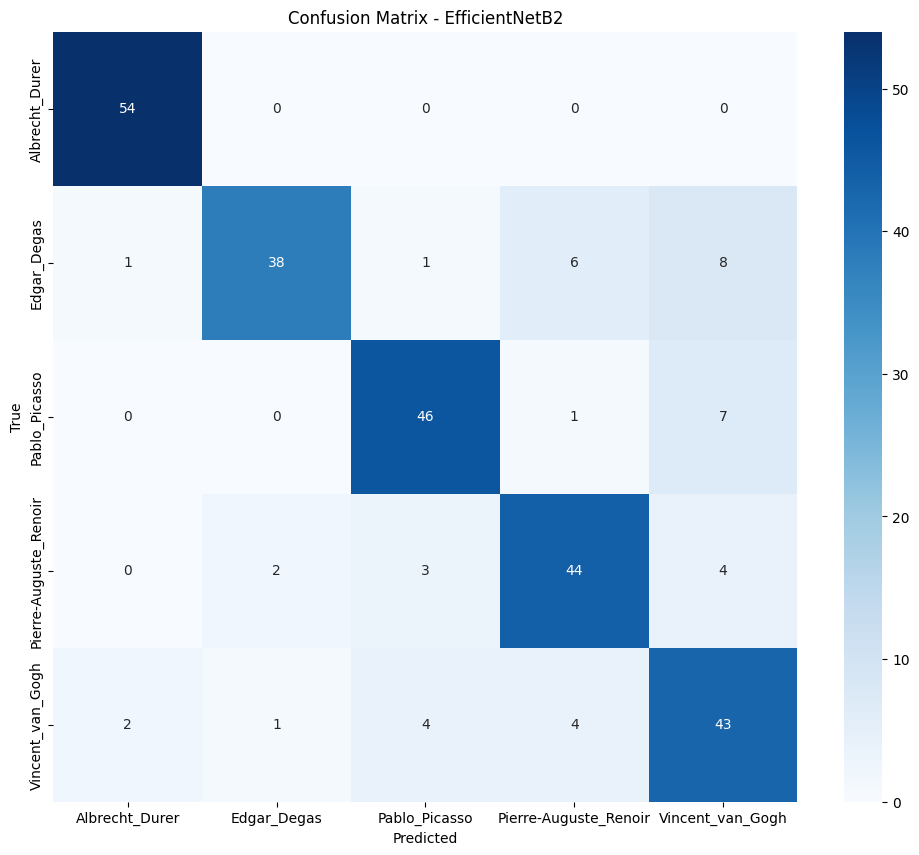

📊 Classification Report :
                        precision    recall  f1-score   support

       Albrecht_Durer       0.95      1.00      0.97        54
          Edgar_Degas       0.93      0.70      0.80        54
        Pablo_Picasso       0.85      0.85      0.85        54
Pierre-Auguste_Renoir       0.80      0.83      0.81        53
     Vincent_van_Gogh       0.69      0.80      0.74        54

             accuracy                           0.84       269
            macro avg       0.84      0.84      0.84       269
         weighted avg       0.84      0.84      0.84       269



In [44]:
# =============================
# 6️⃣ Évaluation finale
# =============================
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"✅ Validation Accuracy : {val_accuracy:.4f}")

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - EfficientNetB2')
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print("📊 Classification Report :\n", report)

##**ResNet50**

###Charger ResNet50 pré-entraîné +fine-tuning

In [45]:
# =============================
# 3️⃣ ResNet50 pré-entraîné + fine-tuning
# =============================
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Ajouter Dropout + classifier final
num_features = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, len(train_dataset.classes))
)

# Geler toutes les couches initiales
for param in resnet.parameters():
    param.requires_grad = False

# Débloquer layer4 (dernier bloc) pour fine-tuning
for param in resnet.layer4.parameters():
    param.requires_grad = True

# Débloquer le classifier
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = resnet.to(device)

###Optimizer

In [46]:
# =============================
# 4️⃣ Criterion et optimizer
# =============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-4)

###Entraînement Fine-tuning

In [47]:
# =============================
# 5️⃣ Entraînement
# =============================
num_epochs = 5
for epoch in range(num_epochs):
    resnet.train()
    running_loss, correct, total = 0.0, 0, 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in progress:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress.set_postfix({
            "loss": f"{running_loss/len(progress):.4f}",
            "acc": f"{correct/total:.4f}"
        })

Epoch 5/5: 100%|██████████| 68/68 [00:14<00:00,  4.67it/s, loss=0.1426, acc=0.9507]


###Évaluation sur validation

✅ Validation Accuracy : 0.8736


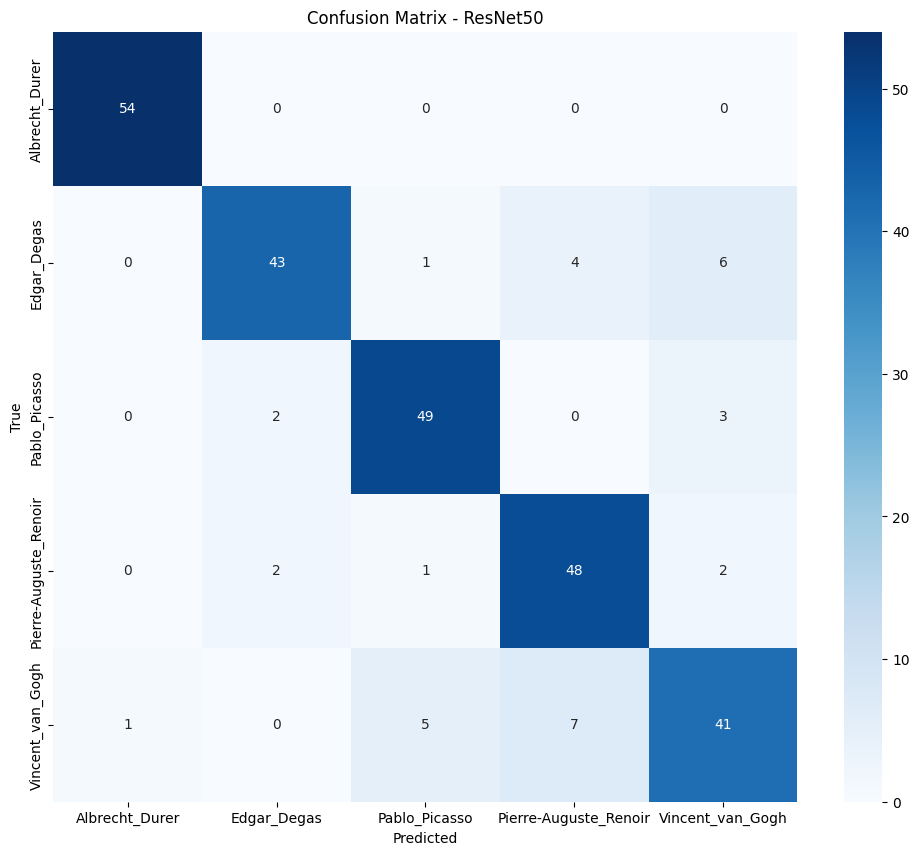

📊 Classification Report :
                        precision    recall  f1-score   support

       Albrecht_Durer       0.98      1.00      0.99        54
          Edgar_Degas       0.91      0.80      0.85        54
        Pablo_Picasso       0.88      0.91      0.89        54
Pierre-Auguste_Renoir       0.81      0.91      0.86        53
     Vincent_van_Gogh       0.79      0.76      0.77        54

             accuracy                           0.87       269
            macro avg       0.87      0.87      0.87       269
         weighted avg       0.87      0.87      0.87       269



In [48]:
# =============================
# 6️⃣ Évaluation finale
# =============================
resnet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"✅ Validation Accuracy : {val_accuracy:.4f}")

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet50')
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print("📊 Classification Report :\n", report)

#**Classification de genre**

##Preparation

In [72]:
# Remplacer les labels 'artist' par 'genre'
# Nous devons re-traiter les images et genres ensemble pour assurer la consistance
# si des images ont été omises lors du chargement initial.

IMG_SIZE = 128
loaded_images_for_genre = []
loaded_genres_raw = []

for idx, row in balanced_df.iterrows():
    img_path = row['filepath']
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        loaded_images_for_genre.append(img)
        loaded_genres_raw.append(row['genre'])

# Convertir en tableaux NumPy
images = np.array(loaded_images_for_genre, dtype='float32') # Mise à jour de la variable images
labels_genre_np = np.array(loaded_genres_raw)

# Encodage numérique des genres
from sklearn.preprocessing import LabelEncoder
le_genre = LabelEncoder()
labels_encoded = le_genre.fit_transform(labels_genre_np) # Mise à jour de la variable labels_encoded

num_classes = len(le_genre.classes_)
print("🎨 Nombre de genres :", num_classes)

🎨 Nombre de genres : 4


In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_encoded,
    test_size=0.2,
    stratify=labels_encoded,
    random_state=42
)

# Encodage one-hot
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


In [74]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=32, shuffle=True)
test_generator = test_datagen.flow(X_test, y_test_cat, batch_size=32, shuffle=False)


In [75]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("⚖️ Poids de classes :", class_weights)


⚖️ Poids de classes : {0: np.float64(1.2490706319702602), 1: np.float64(0.6256983240223464), 2: np.float64(1.2490706319702602), 3: np.float64(1.2490706319702602)}


##Model CNN

In [77]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


##Entrainement + Evaluation

In [78]:
# =============================================
# 🔟 EARLY STOPPING + ENTRAÎNEMENT
# =============================================
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.2989 - loss: 1.5613 - val_accuracy: 0.3929 - val_loss: 1.1766
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5268 - loss: 1.0190 - val_accuracy: 0.7113 - val_loss: 0.7801
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6687 - loss: 0.8547 - val_accuracy: 0.6607 - val_loss: 0.8335
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7194 - loss: 0.8222 - val_accuracy: 0.6875 - val_loss: 0.7587
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7289 - loss: 0.7444 - val_accuracy: 0.6786 - val_loss: 0.7772
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7691 - loss: 0.6247 - val_accuracy: 0.6935 - val_loss: 0.8349
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7745 - loss: 0.6105 - val_accuracy: 0.5833 - val_loss: 0.9482
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8117 - loss: 0.5205 - val_accuracy: 0.7321 - val_loss: 0.

In [79]:
# ---------------------------------------------
# 🔬 ÉVALUATION
# ---------------------------------------------
loss, acc = model.evaluate(test_generator)
print(f"🎯 Précision finale sur test : {acc*100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7015 - loss: 0.7434
🎯 Précision finale sur test : 68.75%


##**Transfer Learning with EfficientNetB0**

In [80]:

class ArtGenreDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

        # Extraire la liste des classes (genres)
        self.classes = sorted(self.df["genre"].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filepath"]
        label_name = self.df.loc[idx, "genre"]
        label = self.class_to_idx[label_name]

        # Charger l'image
        image = Image.open(img_path).convert("RGB")

        # Appliquer les transformations
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [99]:
# ===============================
# 2️⃣ Transformations & DataLoaders
# ===============================
train_tfms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((128, 128)), # Should be 128x128 for consistency
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Split the balanced_df into train and validation sets for genre classification
train_df, val_df = train_test_split(
    balanced_df,
    test_size=0.2,
    stratify=balanced_df['genre'], # Stratify by genre to maintain class distribution
    random_state=42
)

train_dataset = ArtGenreDataset(train_df, transform=train_tfms)
val_dataset = ArtGenreDataset(val_df, transform=val_tfms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

In [103]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


In [104]:
import torch
import torch.nn as nn
from torchvision import models

model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)

num_features = model.classifier[1].in_features
num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(num_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [107]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


In [108]:
# ===============================
# 4️⃣ Entraînement
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        batch_loss = running_loss / (len(progress_bar) if len(progress_bar) else 1)
        batch_acc = correct / total
        progress_bar.set_postfix({
            'loss': f"{batch_loss:.4f}",
            'acc': f"{batch_acc:.4f}"
        })


Epoch 5/5: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s, loss=0.3283, acc=0.8936]


✅ Validation Loss : 0.2858
✅ Validation Accuracy : 0.9196


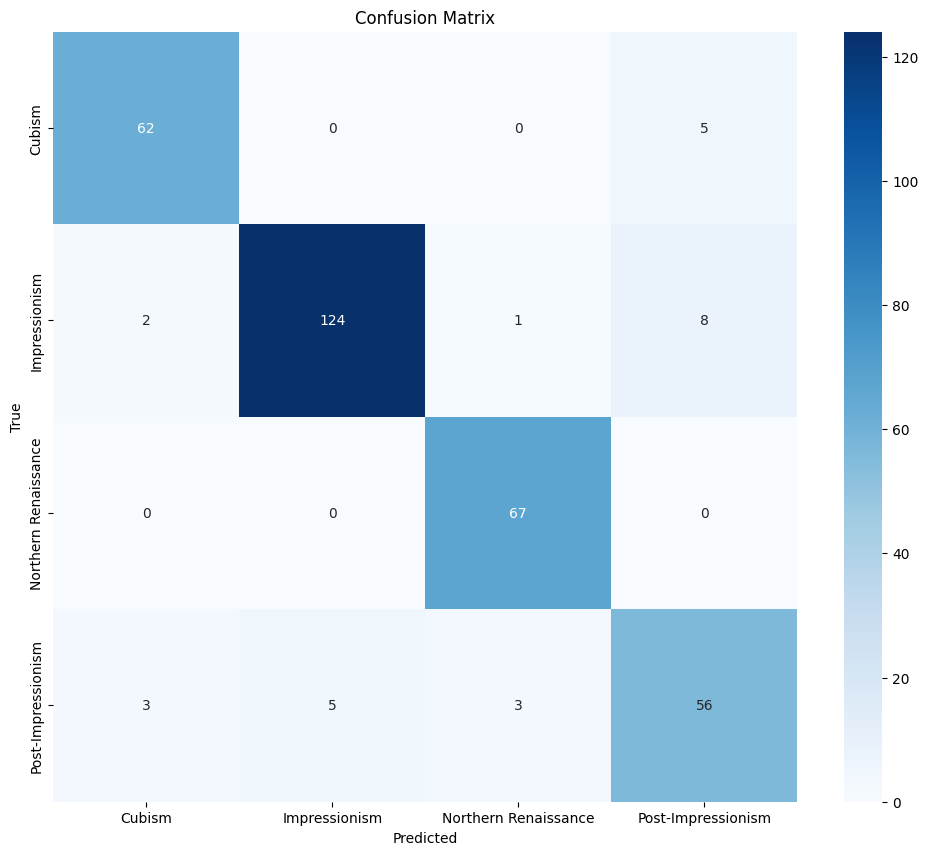

📊 Classification Report :
                       precision    recall  f1-score   support

              Cubism       0.93      0.93      0.93        67
       Impressionism       0.96      0.92      0.94       135
Northern Renaissance       0.94      1.00      0.97        67
  Post-Impressionism       0.81      0.84      0.82        67

            accuracy                           0.92       336
           macro avg       0.91      0.92      0.91       336
        weighted avg       0.92      0.92      0.92       336



In [109]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# ===============================
# Évaluation complète
# ===============================
model.eval()
all_preds = []
all_labels = []

val_loss = 0.0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy globale
val_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
val_loss = val_loss / len(val_loader)

print(f"✅ Validation Loss : {val_loss:.4f}")
print(f"✅ Validation Accuracy : {val_accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Rapport de classification
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print("📊 Classification Report :\n", report)


##**ResNet50**

### Modèle ResNet50

In [110]:
# ===============================
# 3️⃣ Modèle ResNet50
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, len(train_dataset.classes))  # nombre de genres

resnet = resnet.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:05<00:00, 17.3MB/s]


In [111]:

# ===============================
# 4️⃣ Entraînement
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4)
num_epochs = 5

for epoch in range(num_epochs):
    resnet.train()
    running_loss, correct, total = 0.0, 0, 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        batch_loss = running_loss / (len(progress_bar) if len(progress_bar) else 1)
        batch_acc = correct / total
        progress_bar.set_postfix({
            'loss': f"{batch_loss:.4f}",
            'acc': f"{batch_acc:.4f}"
        })

Epoch 5/5: 100%|██████████| 168/168 [00:19<00:00,  8.63it/s, loss=0.2232, acc=0.9234]


###Evaluation

In [112]:
# ===============================
# 7️⃣ Évaluation
# ===============================
resnet.eval()
val_correct, val_total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

val_acc = val_correct / val_total
print(f"✅ Accuracy sur le set de validation : {val_acc:.4f}")

✅ Accuracy sur le set de validation : 0.9137
